# Catalogue Afterpulse

The aim of this notebook is to create a framework whereby set of 3 candidate afterpulse files can be laoded in and checked to see which produce valid afterepulse signals.

It will utilise some of the code from `investigate_afterpulse_by_day.ipynb` to get days when three afterpulse candidate files are present.

It will then plot data from each of the three valid files, and ask the user which, if any, appear to be valid afterpulse files.

In [7]:
import mplgz_to_ingested as mplgz
import xarray as xr
import matplotlib.pyplot as plt
import glob
import numpy as np
import os.path as path

In [2]:
# root directory, get filenames
dir_root = '/gws/nopw/j04/ncas_radar_vol2/data/ICECAPSarchive/mpl/raw'
candidateFiles = mplgz.afterpulse.get_all_afterpulse_candidates(dir_root)

In [3]:
# the calibration files start earnestly from 2016 onwards, so I'll remove the first 4 elements from the list
tocheck = candidateFiles[4:]

In [4]:
# determine which days have 3 candidate files
n_per_day = {}

for f in tocheck:
    year = f[:4]
    if year not in n_per_day:
        n_per_day[year] = {}

    month = f[4:6]
    if month not in n_per_day[year]:
        n_per_day[year][month] = {}

    day = f[6:8]
    if day not in n_per_day[year][month]:
        n_per_day[year][month][day] = 0

    n_per_day[year][month][day] += 1

days_of_three = []

for year in n_per_day:
    for month in n_per_day[year]:
        for day in n_per_day[year][month]:
            if n_per_day[year][month][day] == 3:
                days_of_three.append(year + month + day)

print(days_of_three)
print(len(days_of_three))

['20160126', '20160224', '20160323', '20160427', '20160527', '20160605', '20160625', '20160725', '20160907', '20161129', '20161228', '20170130', '20170328', '20170427', '20170620', '20170720', '20170821', '20170919', '20171019', '20171123', '20171219', '20180119', '20180213', '20180314', '20180413', '20180514', '20180617', '20180718', '20180820', '20180917', '20181018', '20181120', '20181220', '20190212', '20190415', '20190516', '20190711', '20190714', '20190819', '20190914', '20191015', '20191214', '20200116', '20200214', '20200316', '20200417', '20200516', '20200615', '20200715', '20200815', '20200915', '20201015', '20201115', '20201215', '20210115', '20210219', '20210315', '20210415', '20210515', '20220714', '20220815', '20220915', '20221031', '20221130', '20221230', '20230210', '20230212', '20230312', '20230412']
69


In [12]:
days_of_three.index('20221230')

64

## Cataloguing program

In order to start creating the catalogue, run the following cell.

1. Designate an ouput file for the afterpulse filenames to be stored in.
2. Assign a number of `days of three` to skip. This can allow for the catalogue to be generated in batches.
3. For each `day of three`, the available input options are:

- 1: the first file is the valid afterpulse file
- 2: the second file is the valid afterpulse file
- 3: the third file is the valid afterpulse file
- n: none of the files produce valid afterpulse signals
- h: halt the program and save the currently designated afterpulse catalogue

Afterpulse files that are valid should have the following properties:
1. The time-averaged signal should extend from range index 0 to 2000
2. The time averaged signal should be strongest at the ground and (ignoring noise) should monotonically decrease with altitude
3. No cloud-like signals in the afterpulse signal
4. The length of time the afterpulse should be recorded over should only be in the 10s of profiles.

Break from catalogue, or end reached.
3 days_of_three out of 69 catalogued. (unless halted, then 2)


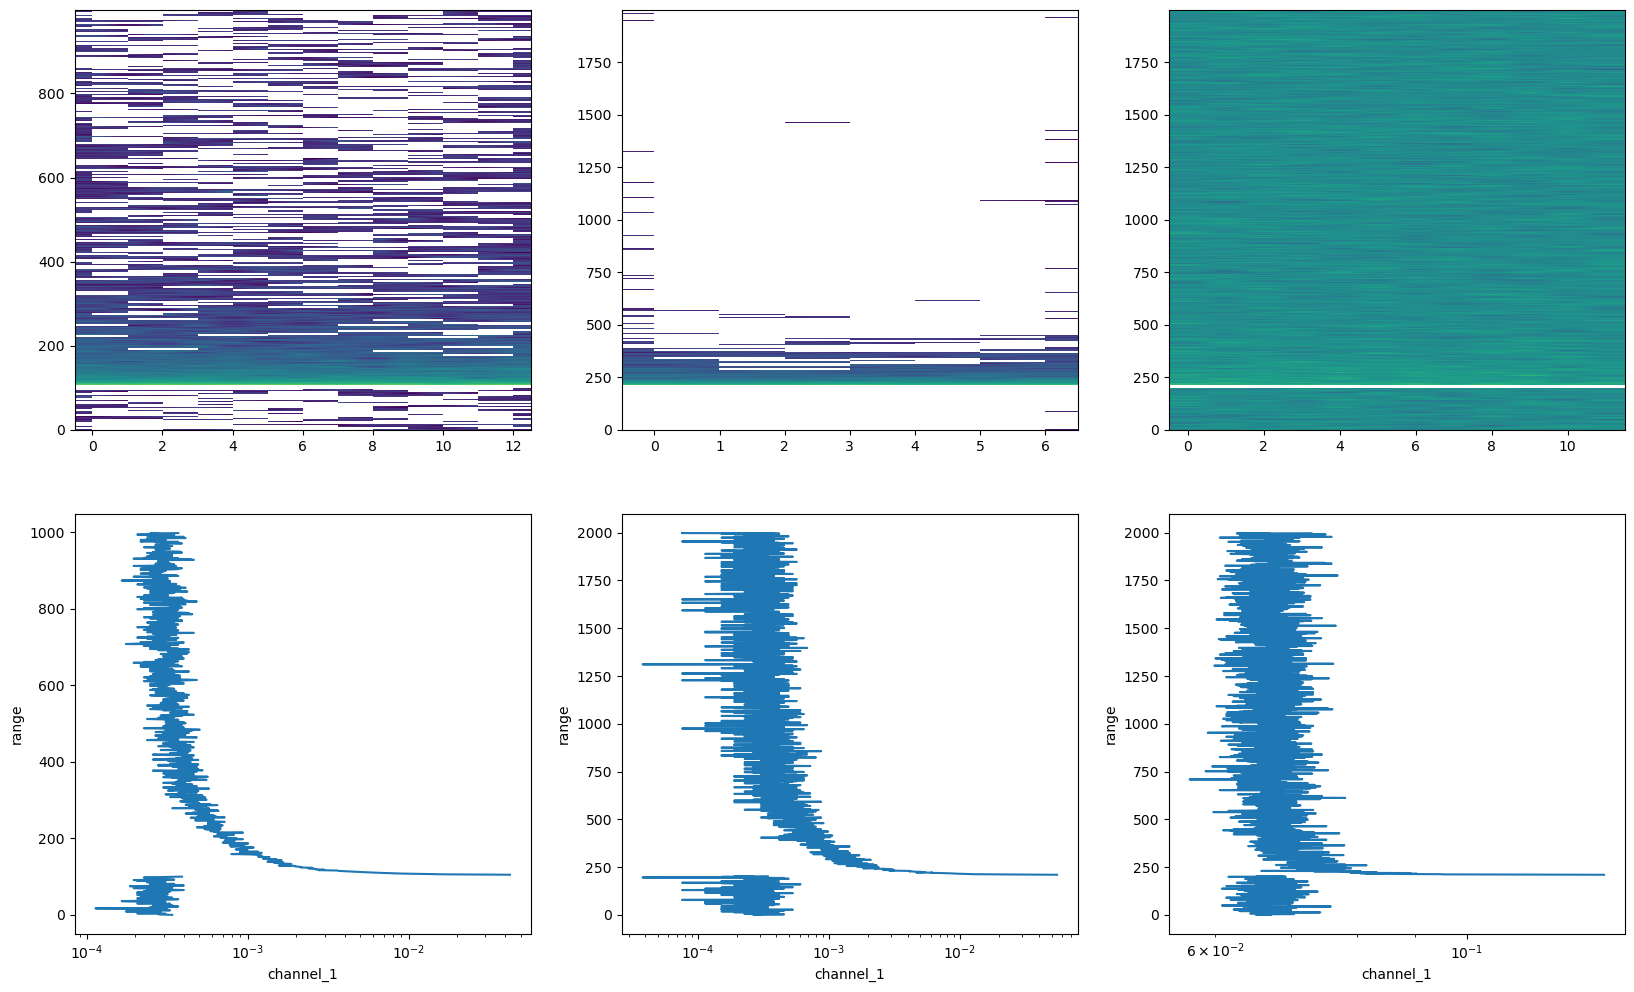

In [13]:
# setup for the catalogue file to be saved
fname = input('What file would you like to save the catalogue in (file extension required): ')
try:
    f = open(fname, 'x') # creates the file (touch), returns error if it already exists
    print(f'File {fname} created.')
except Exception as err:
    print(f'File {fname} already exists, or another error has occured.')
    print(err)
    cont = input('Continue? This will append to the file that already exists [y/n]')
    if cont.lower() != 'y':
        raise KeyboardInterrupt
        # halt the cell if we don't want to continue

# we are happy with the filename...
skip = int(input('How many items would you like to skip?'))


fig = plt.figure(figsize=(20,12))
axs = fig.subplots(2,3)

from IPython import display

for i,daystr in enumerate(days_of_three[skip:]):

    # get the three files associated with calbration candidates for that day
    globstr = daystr + '*.mpl.gz'

    dayfiles = glob.glob(globstr, root_dir=dir_root)
    calibFiles = sorted([f for f in dayfiles if f[-9:] != '00.mpl.gz'])

    ds1 = mplgz.load.load_mplgz(path.join(dir_root,calibFiles[0]))
    ds2 = mplgz.load.load_mplgz(path.join(dir_root,calibFiles[1]))
    ds3 = mplgz.load.load_mplgz(path.join(dir_root,calibFiles[2]))


    for d,a in zip([ds1,ds2,ds3],axs[0]):
        a.cla()
        a.imshow(np.log10(d.channel_1.where(d.channel_1<0.5)).values.T,aspect='auto',origin='lower')

    for d,a in zip([ds1,ds2,ds3],axs[1]):
        a.cla()
        d.channel_1.where(d.channel_1<1).mean(dim='profile').plot(y='range',ax=a)
        a.set_xscale('log')

    display.display(fig)
    display.clear_output(wait=True)
    opt = input('Catalogue option: [1,2,3,n,h]')
    if opt == 'h':
        break
    elif opt == 'n':
        continue
    elif opt == '1':
        catstr = calibFiles[0]
    elif opt == '2':
        catstr = calibFiles[1]
    elif opt == '3':
        catstr = calibFiles[2]
    else:
        print(f'invalid input, skipping for now, this is index {i}')
    # should only reach this part if valid file has been selected
    f = open(fname,'a')
    f.write(f', {catstr}')
    f.close()

print('Break from catalogue, or end reached.')
print(f'{i+1} days_of_three out of {len(days_of_three[skip:])} catalogued. (unless halted, then {i})')